# 로지스틱 회귀모델

In [37]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.api import Logit

from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import confusion_matrix,classification_report

In [38]:
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rc("axes",unicode_minus = False) 

## Data Scaling 이전

In [39]:
df_raw = pd.read_csv("./실습화일/2. Big Data 분석/HMEQ.csv", encoding='euc-kr')

df_raw['JOB'].fillna('Other', inplace = True)
df_raw.fillna(df_raw.mean(), inplace = True)

df_train,df_test = train_test_split(df_raw, test_size =0.3, random_state=1234)
print('train data size: {}'.format(df_train.shape))
print('train data size: {}'.format(df_test.shape))

train data size: (2623, 13)
train data size: (1125, 13)


In [40]:
# C 로 묶은 변수는 범주형 변수 표시. get_dummies 가 필요없음
# [T.변수] 로 해당 값의 값 표현
log_model = Logit.from_formula('''BAD~ LOAN + MORTDUE + VALUE + C(REASON)\
       +C(JOB) +YOJ + DEROG +DELINQ + CLAGE + NINQ + CLNO+ DEBTINC''',df_train)
log_result =log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Fri, 14 Jul 2023   Pseudo R-squ.:                  0.2257
Time:                        22:31:44   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

1. 설명력 : 0.2257 -> 로지스틱 회귀분석의 설명력은 낮음
2. 회귀계수의 유의성 검정 -> C 범주형 변수에서 하나만 0.05보다 작으면 유의하다.

즉, C(JOB)[T.Office] < 0.05 이므로 변수 JOB은 유의하다고 판단할 수 있다.

-> 근데 왜 유의하지 않은 변수는 제거하지 않을까?? *

In [41]:
y_pred_train = log_result.predict(df_train)
# 예측확률을 0.5를 기준으로 분류
y_pred_train_class = (y_pred_train > 0.5).astype(int)
print('Train 예측 결과 \n', y_pred_train_class.head(),'\n')
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_train['BAD'],y_pred_train_class)),'\n')

Train 예측 결과 
 3164    0
3314    1
93      0
1456    0
3327    0
dtype: int32 

Confusion Matrix:
[[2365   17]
 [ 190   51]] 



In [42]:
y_pred_test = log_result.predict(df_test)
# 1/0 판정하는 임계값 변경 가능 
y_pred_test_class = (y_pred_test > 0.5). astype(int)
print('Train 예측 결과 \n', y_pred_train_class.head(),'\n')
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_train['BAD'],y_pred_train_class)),'\n')

Train 예측 결과 
 3164    0
3314    1
93      0
1456    0
3327    0
dtype: int32 

Confusion Matrix:
[[2365   17]
 [ 190   51]] 



In [43]:
print('Train 예측/분류 결과')
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_train['BAD'], y_pred_train_class)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_train['BAD'],y_pred_train_class)),'\n')
print(classification_report(df_train['BAD'], y_pred_train_class, digits=3))


print('Test 예측/분류 결과')
print('Accuracy: {0:.3f}\n'.format(accuracy_score(df_test['BAD'], y_pred_test_class)))
print('Confusion Matrix: \n{}'.format(confusion_matrix(df_test['BAD'],y_pred_test_class)),'\n')
print(classification_report(df_test['BAD'], y_pred_test_class, digits=3))

Train 예측/분류 결과
Accuracy: 0.921

Confusion Matrix:
[[2365   17]
 [ 190   51]] 

              precision    recall  f1-score   support

           0      0.926     0.993     0.958      2382
           1      0.750     0.212     0.330       241

    accuracy                          0.921      2623
   macro avg      0.838     0.602     0.644      2623
weighted avg      0.909     0.921     0.900      2623

Test 예측/분류 결과
Accuracy: 0.924

Confusion Matrix: 
[[1017    4]
 [  81   23]] 

              precision    recall  f1-score   support

           0      0.926     0.996     0.960      1021
           1      0.852     0.221     0.351       104

    accuracy                          0.924      1125
   macro avg      0.889     0.609     0.656      1125
weighted avg      0.919     0.924     0.904      1125



<Axes: >

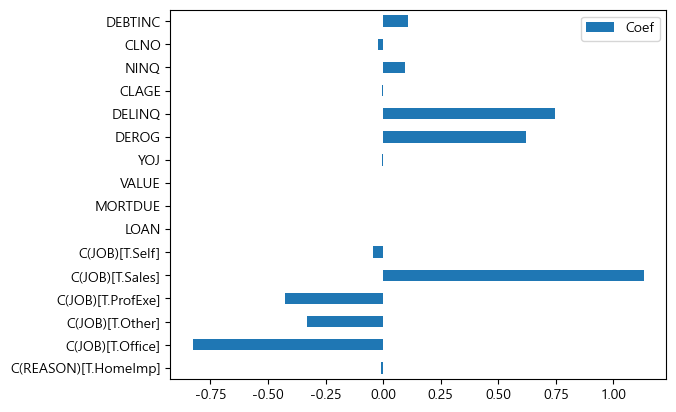

In [44]:
df_logistic_coef = pd.DataFrame({'Coef':log_result.params.values[1:]},
                                index = log_model.exog_names[1:])
df_logistic_coef.plot.barh(y= 'Coef')

### Data Scaling 이전 결과

작업이 Sales이거나, 연체된 신용한도의 수 (DELINQ)와 심각한 연체 수 (DEROG)가 높을 경우,
대출 채무 불이행(BAD)일 가능성이 높아짐.

직업이 Office면 대출 채무 불이행(BAD)일 가능성이 낮아짐.

## Data Scaling 이후 변화

In [45]:
# 목표변수는 제외
df_raw_y = df_raw['BAD']
df_raw = df_raw.drop('BAD', axis=1)

# 범주형은 제외한 수치하여 데이터만 Data Scaling 진행
df_char =df_raw.select_dtypes(include = 'object')
df_numeric =df_raw.select_dtypes(exclude = 'object')

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled=pd.DataFrame(np_numeric_scaled, columns =df_numeric.columns)


df_scaled= pd.concat([df_raw_y,df_numeric_scaled, df_char], axis =1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [46]:
df_scaled_train, df_scaled_test = train_test_split(df_scaled, test_size =0.3, random_state = 1234)

In [47]:
scaled_log_model = Logit.from_formula('''BAD~ LOAN + MORTDUE + VALUE + C(REASON) +C(JOB) +YOJ + DEROG +DELINQ + CLAGE + NINQ + CLNO+ DEBTINC''',df_scaled_train)

scaled_log_result = scaled_log_model.fit()

print(scaled_log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Fri, 14 Jul 2023   Pseudo R-squ.:                  0.2257
Time:                        22:34:24   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -2.4815      0.205    -12.111      0.000      -2.883      -2.080

<Axes: >

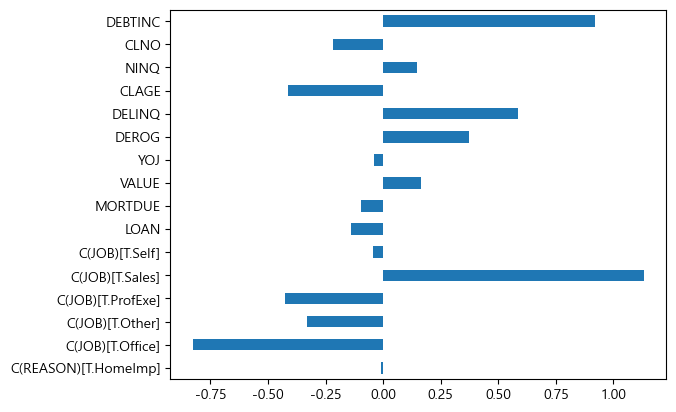

In [48]:
df_log_scaled_coef = pd.DataFrame({'Coef': scaled_log_result.params.values[1:]},
                                 index = scaled_log_model.exog_names[1:])
df_log_scaled_coef.plot.barh(y='Coef', legend=False)

### Data Scaling 이전 결과

직업이 Sales이거나, 부채비율(DEBTINC)와 연체된 신용한도의 수(DELINQ)가 높을 경우 대출 채무 불이행(BA)일 가능성이 높아짐.

특히 부채비율(DEBTINC)의 영향이 커짐

직업이 Office일 경우 대출 채무 불이행(BAD)일 가능성이 낮아짐

## Data Scaling 전, 후 차이점

가장 큰 변화는 채무 불이행에 많은 영향을 미치지 못했던 부채 비율이 Scaling 후에는 크게 영향을 주게 변화한 것이다. 

Scaling 하지 않은 상태에서 부채 비율이 목표변수에 큰 영향을 주지 못한 이유는 아마 다른 변수들이 부채 비율보다 큰 값을 갖고 있어서 영향력이 희석되었을 가능성이 높다.

But, Scaling 이후에는 변수들의 크기가 조정되어 부채 비율이 다른 변수들과 비슷한 크기를 갖게 된다. 이로 인해 부채 비율의 영향력이 드러나게 되었을 것이다.
